In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import skew, kurtosis
import os
import random
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
import pandas as pd
from scipy.fftpack import fft, fftfreq
from scipy.signal import peak_widths, peak_prominences
from scipy.io import loadmat
import seaborn as sns
from scipy.signal import spectrogram

## Dataframe of all signals

##### According to the documents on Z24 only R1V, R2L, R2T, R2V, R3V are present in every setup. Other sensors are moved around during every setup making them difficult to use as reliable channels

In [2]:
def get_avt_files(root):
    folder_path = root
    file_list = os.listdir(folder_path)
    avt_files = []

    # walk inside data folder
    for filename in file_list:
        full_path = os.path.join(folder_path, filename)
        cur_label = int(filename)

        # walk inside data/[number]
        file_nest_list = os.listdir(full_path)
        for filename_1 in file_nest_list:
            if filename_1 != "avt":
                continue
            else:
                # full_path_2 is of the form C:\Users\amroa\Documents\thesis\data\01\avt
                full_path_2 = os.path.join(full_path, filename_1)
                setup_filenames = [filename for filename in os.listdir(full_path_2) if "setup" in filename]
                for avt_file in setup_filenames:
                    full_path_3 = os.path.join(full_path_2, avt_file) # full_path_3 is of the form C:\Users\amroa\Documents\thesis\data\01\avt\01setup09.mat
                    avt = loadmat(full_path_3)
                    avt_files.append(avt)
    return avt_files

In [3]:
def get_dataframes(avt_files):
    """
    This method returns a list of dataframes # type: ignore
    A dataframe is of the form: # type: ignore
    R1V R2L ... R3V  (column names)
    0.1 0.3 ... 0.12
    0.4 0.1 ... 0.22 
    """
    good_sensors = ['R1V ', 'R2L ', 'R2T ', 'R2V ', 'R3V ']
    result = pd.DataFrame(columns=good_sensors)
    list_df = [] # should contain 17 entries, one for each damage state 

    # get pandas dataframes
    for idx, avt in enumerate(avt_files):
        # get index of the good sensor/positions
        arr_sensors = avt['labelshulp']
        bool_array = np.isin(arr_sensors, good_sensors) #  will contain True if entry corresponds to a good sensor
        indices_good_sensors = np.where(bool_array)[0]

        # Create a Pandas DataFrame
        df = pd.DataFrame(data=avt['data'][:, indices_good_sensors], columns=arr_sensors[indices_good_sensors])
        result = pd.concat([result, df], ignore_index=True)

        if (idx+1) % 9 == 0:
            # Most of the dataframes are 589824 except for 4 of them
            # Mirror the top part to the bottom to achive the same length
            top_rows = result.head(589824 - len(result))

            # Concatenate the sliced rows to the bottom of the original DataFrame
            new_res = pd.concat([result, top_rows], ignore_index=True)

            list_df.append(new_res)
            result = pd.DataFrame(columns=good_sensors)

    return list_df

In [4]:
avt_files = get_avt_files("C:\\Users\\amroa\\Documents\\thesis\\data")
dfs = get_dataframes(avt_files)

In [5]:
dfs[2]

R1V       R2L       R2T           R2V       R3V 
0      -6.066895e-05 -0.000005 -0.000055  2.292960e-04  0.000126
1      -2.200317e-05 -0.000008 -0.000050  1.158061e-04  0.000062
2       4.150391e-06 -0.000007 -0.000033 -3.474182e-05  0.000061
3       4.107666e-05 -0.000009 -0.000023 -1.038394e-04 -0.000062
4       8.563232e-05 -0.000015 -0.000031 -1.293168e-04 -0.000184
...              ...       ...       ...           ...       ...
589819 -3.051758e-08 -0.000002 -0.000012 -1.930101e-07 -0.000018
589820 -3.051758e-08 -0.000006 -0.000018 -1.930101e-07  0.000032
589821  1.983643e-06 -0.000012 -0.000011  3.879503e-05  0.000076
589822 -4.852295e-06 -0.000014 -0.000002  1.022954e-04  0.000110
589823 -4.211426e-06 -0.000014 -0.000014  1.694629e-04  0.000119

[589824 rows x 5 columns]

In [6]:
from preprocess import preprocess, preprocess_without_std
# Function takes as input window size (16384), the dataframes containing the data, test_split is 1 and window_size is 16384 means 1 out of (589,824/16,384) of the data is used for testing
def get_train_test(dataframes, standardize = True, test_split = 1, window_size = 16384):

    preprocess_function = (lambda x : preprocess(x)) if standardize else (lambda x : preprocess_without_std(x))
    labels_train = np.array([])
    labels_test = np.array([])

    train_data = []
    test_data = []

    for idx, df in enumerate(dataframes):
        nbr_splits = int(len(df)//window_size)  # test_split of these will be used for testing. len(df) = 589,824. nbr_splits = 36
        test_indices = random.sample(range(nbr_splits), test_split)
        train_indices = [x for x in range(nbr_splits) if x not in test_indices]
        for i in train_indices:
            labels_train = np.append(labels_train, idx)
            train_data_i = df.iloc[i*window_size: (i+1)*window_size].values
            data_i = np.apply_along_axis(preprocess_function, axis = 0, arr= train_data_i)
            train_data.append(data_i)
        for i in test_indices:
            labels_test = np.append(labels_test, idx)
            test_data_i = df.iloc[i*window_size: (i+1)*window_size].values
            data_i = np.apply_along_axis(preprocess_function, axis= 0, arr= test_data_i)
            test_data.append(data_i)

    return np.array(train_data), labels_train, np.array(test_data), labels_test 


In [7]:
train_data, labels_train, test_data, labels_test = get_train_test(dfs, standardize=False)

In [8]:
test_data.shape, train_data.shape, labels_train.shape

((17, 16384, 5), (595, 16384, 5), (595,))

## Spectrogram

We take the average spectrogram of each damage class

In [151]:
def plot_spectrogram(signals, title):
    fs = 100  # 100 samples/second
    T = 1.0 / fs  # time between consecutive samples
    t = np.arange(0, len(signals[0])/fs, T)  # time vector

    n_rows = 4  
    n_cols = 5  
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle(title, fontsize=20, y = 1.01)  # Title for the entire plot

    # iterate through the signals
    for i in range(len(signals)):
        
        # the i'th preprocessed signal 
        y = signals[i]
        
        # calculate the spectrogram
        f, t_spec, Sxx = spectrogram(y, fs)
        
        # select subplot
        plt.subplot(n_rows, n_cols, i+1)
        plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading = 'gouraud')
        plt.ylabel('Freq [Hz]')
        plt.xlabel('Time [s]')
        plt.title(f'State {i+1}')
        plt.colorbar(label='dB', orientation='horizontal', pad=0.2)

    # put spacing between subplots
    plt.tight_layout()
    # adjust subplots so they don't overlap with the main title
    plt.subplots_adjust(top= 0.95)
    plt.show()

In [112]:
# Apply preprocess column wise
dfs_preprocessed = [df.apply(preprocess, axis=0) for df in dfs] 

In [113]:
# take only signals from R3V to plot their spectrogram
r3v_signals = [df.iloc[:, -1].values for df in dfs_preprocessed]

# take signals from R2V
r2v_signals = [df.iloc[:, 3].values for df in dfs_preprocessed]

# take signals from R2T
r2t_signals = [df.iloc[:, 2].values for df in dfs_preprocessed]

# take signals from R2L
r2L_signals = [df.iloc[:, 1].values for df in dfs_preprocessed]

# take signals from R1V
r1v_signals = [df.iloc[:, 0].values for df in dfs_preprocessed]

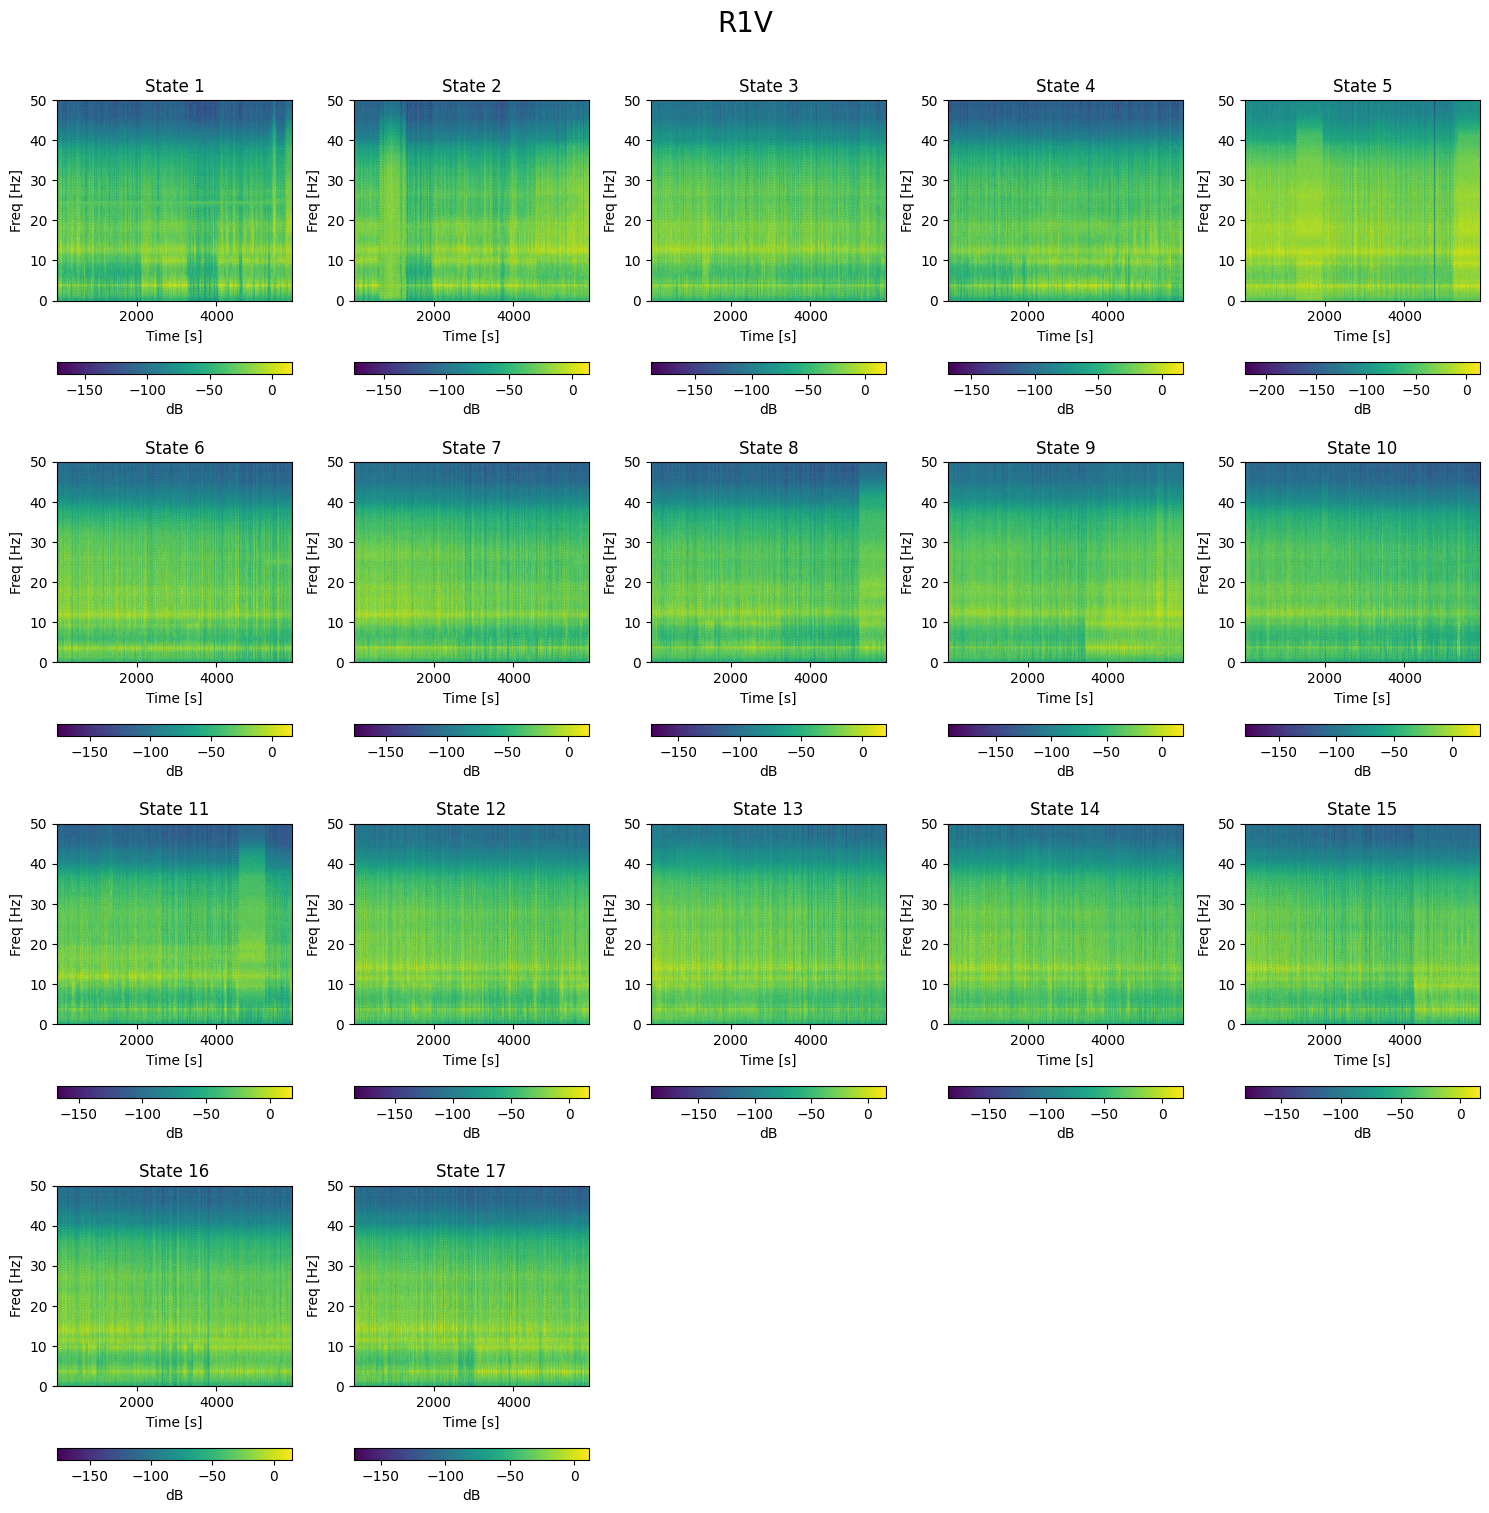

In [152]:
plot_spectrogram(r1v_signals, "R1V")

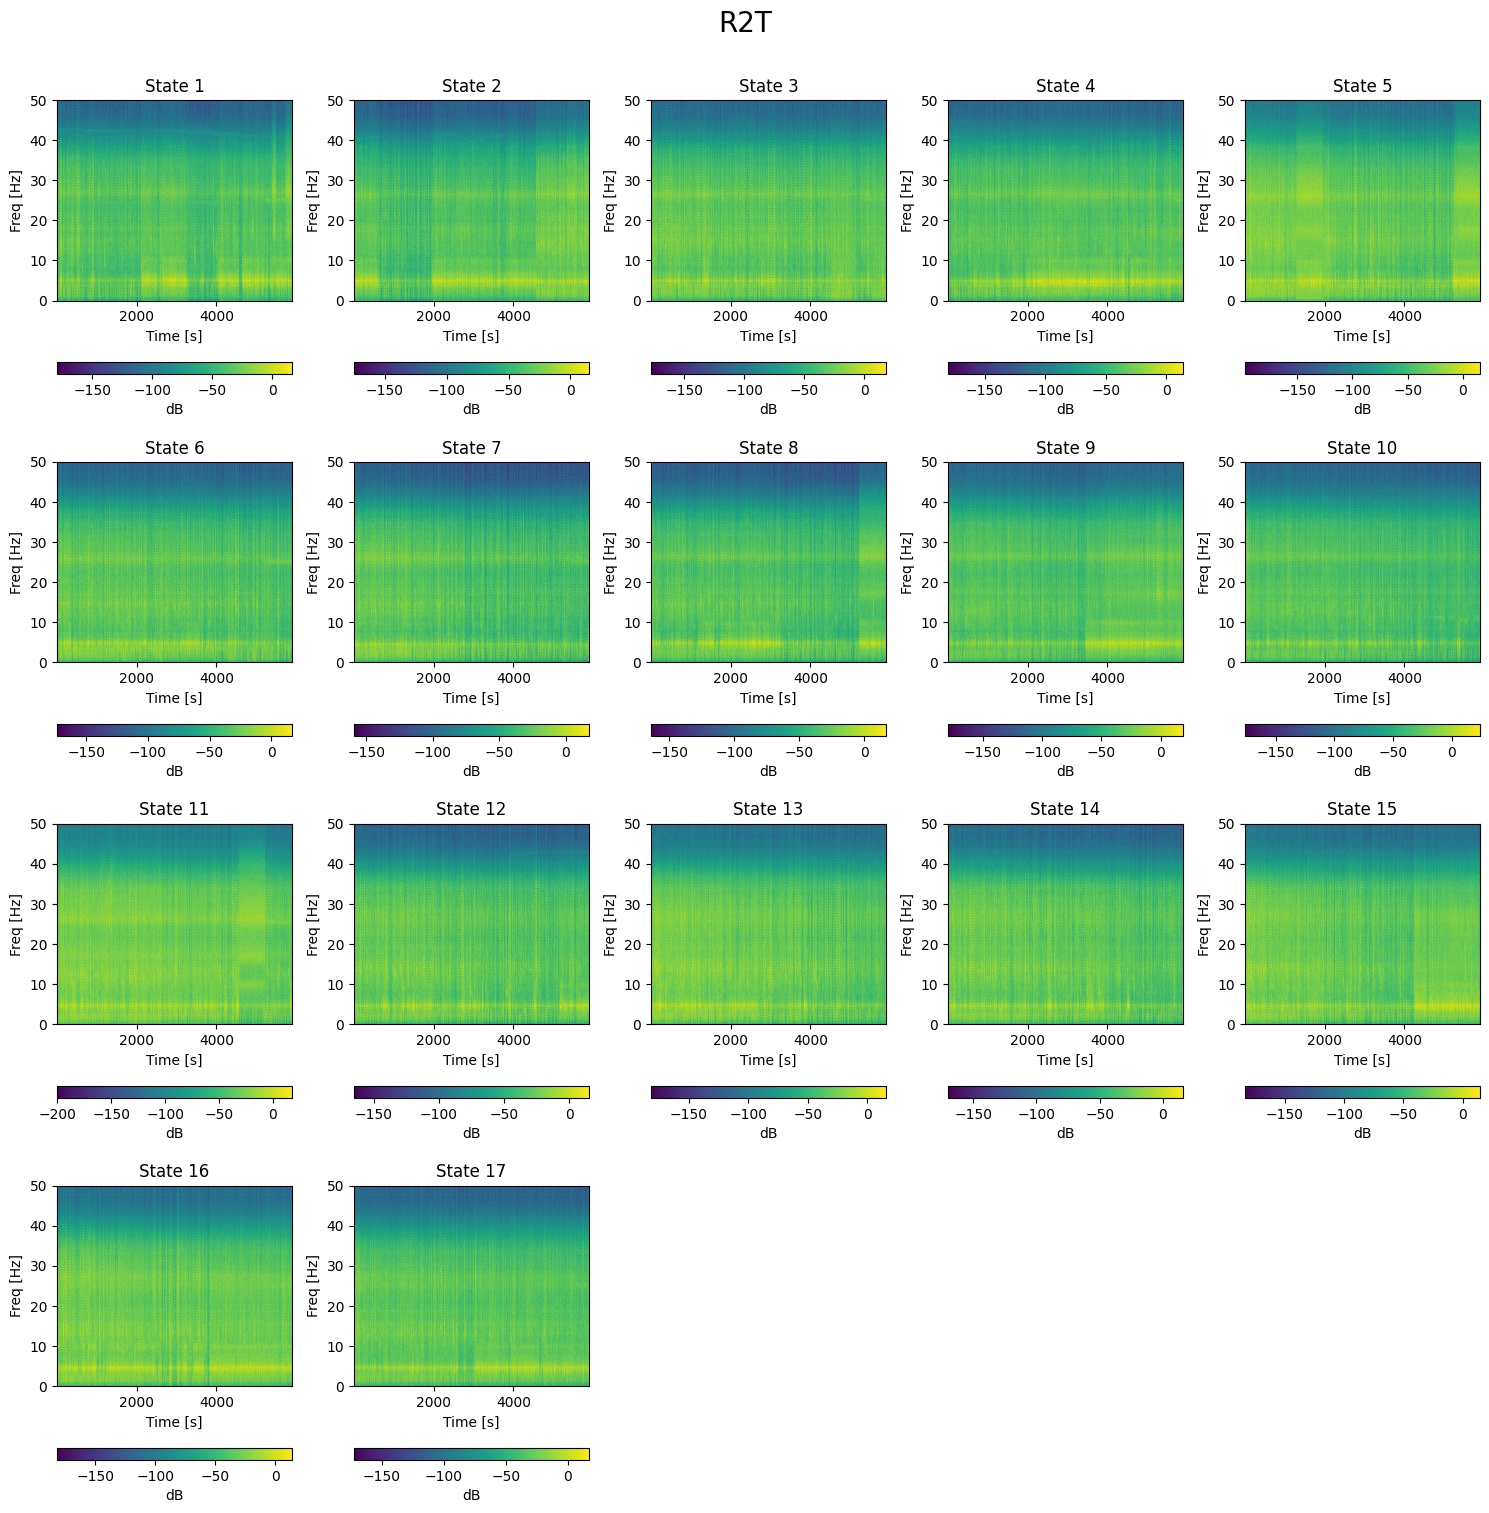

In [57]:
plot_spectrogram(r2t_signals, "R2T")

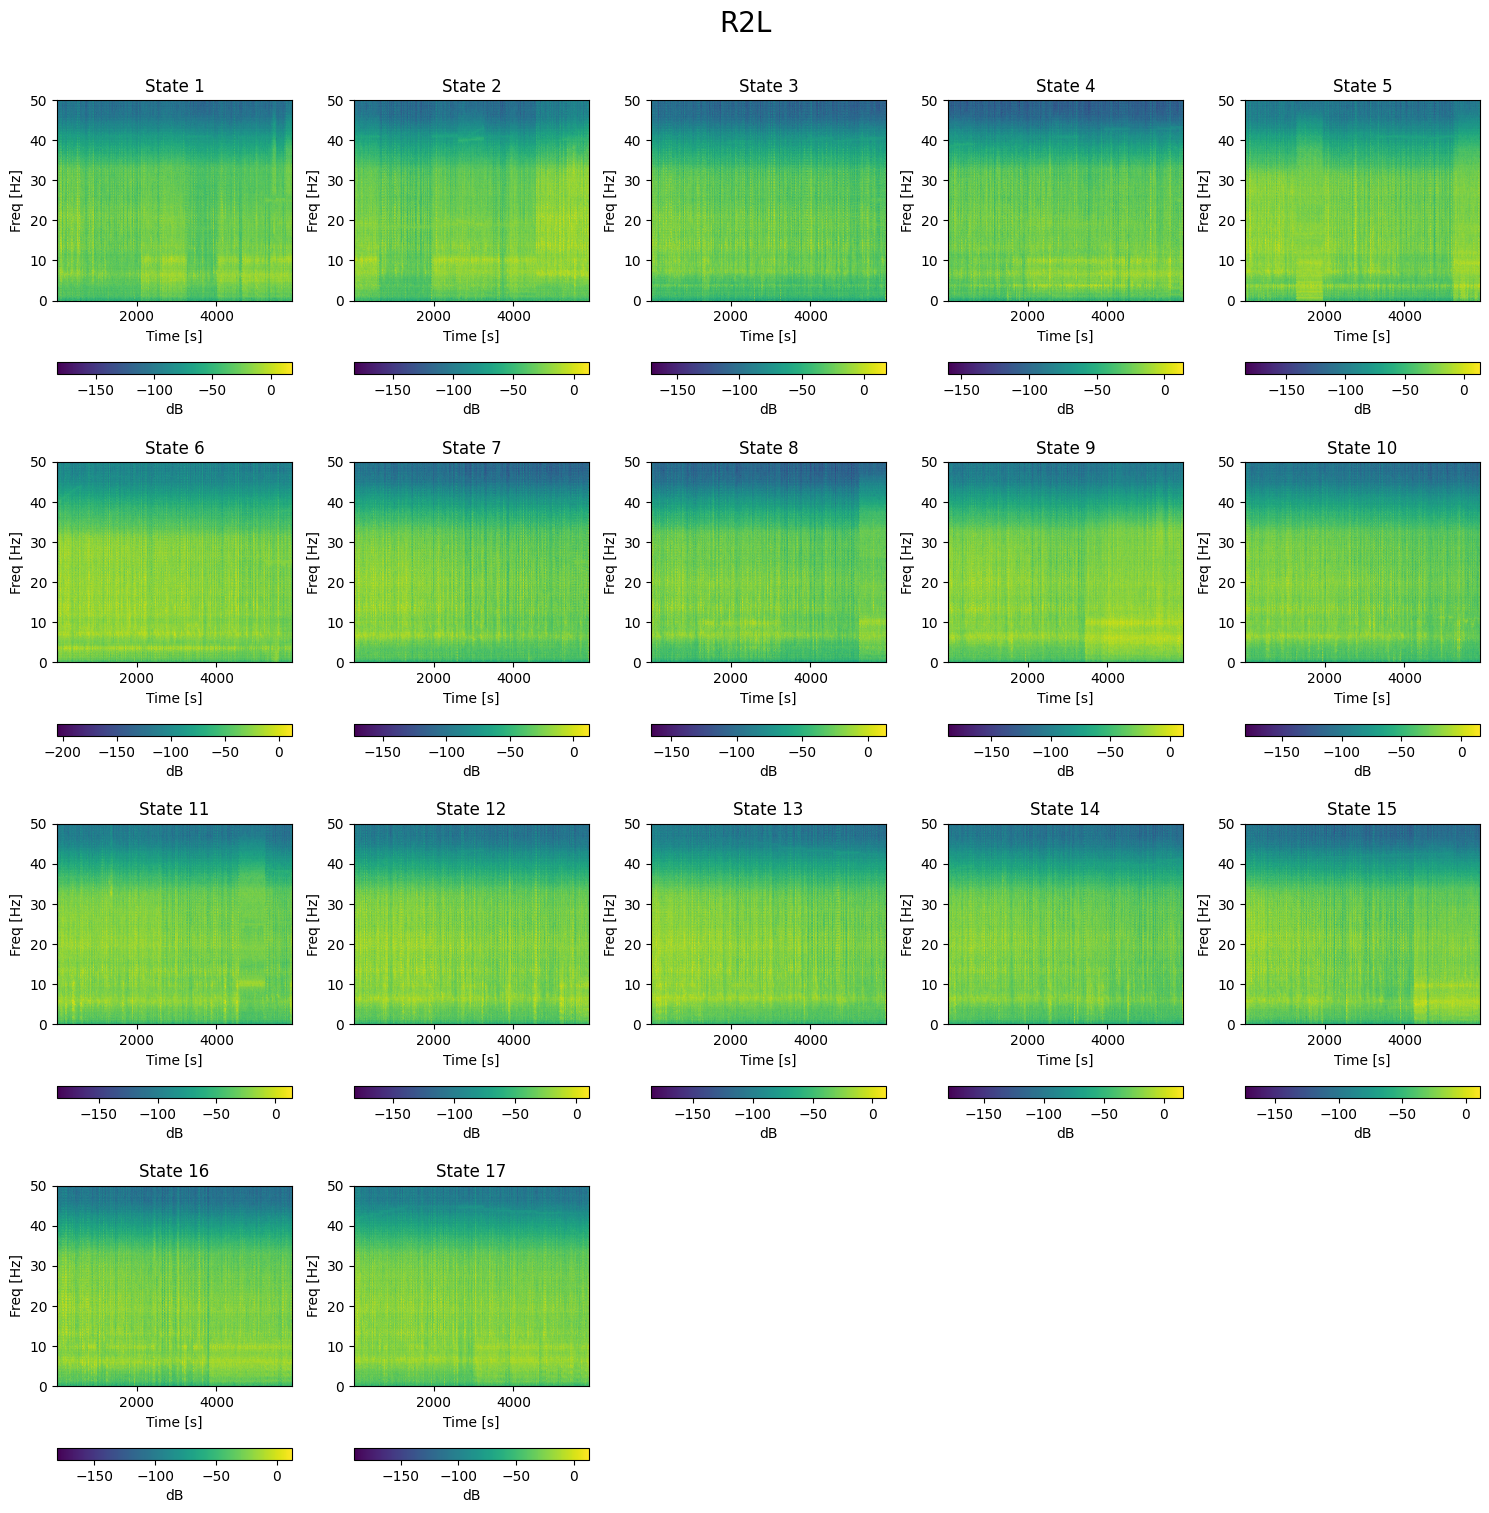

In [56]:
plot_spectrogram(r2L_signals, "R2L")

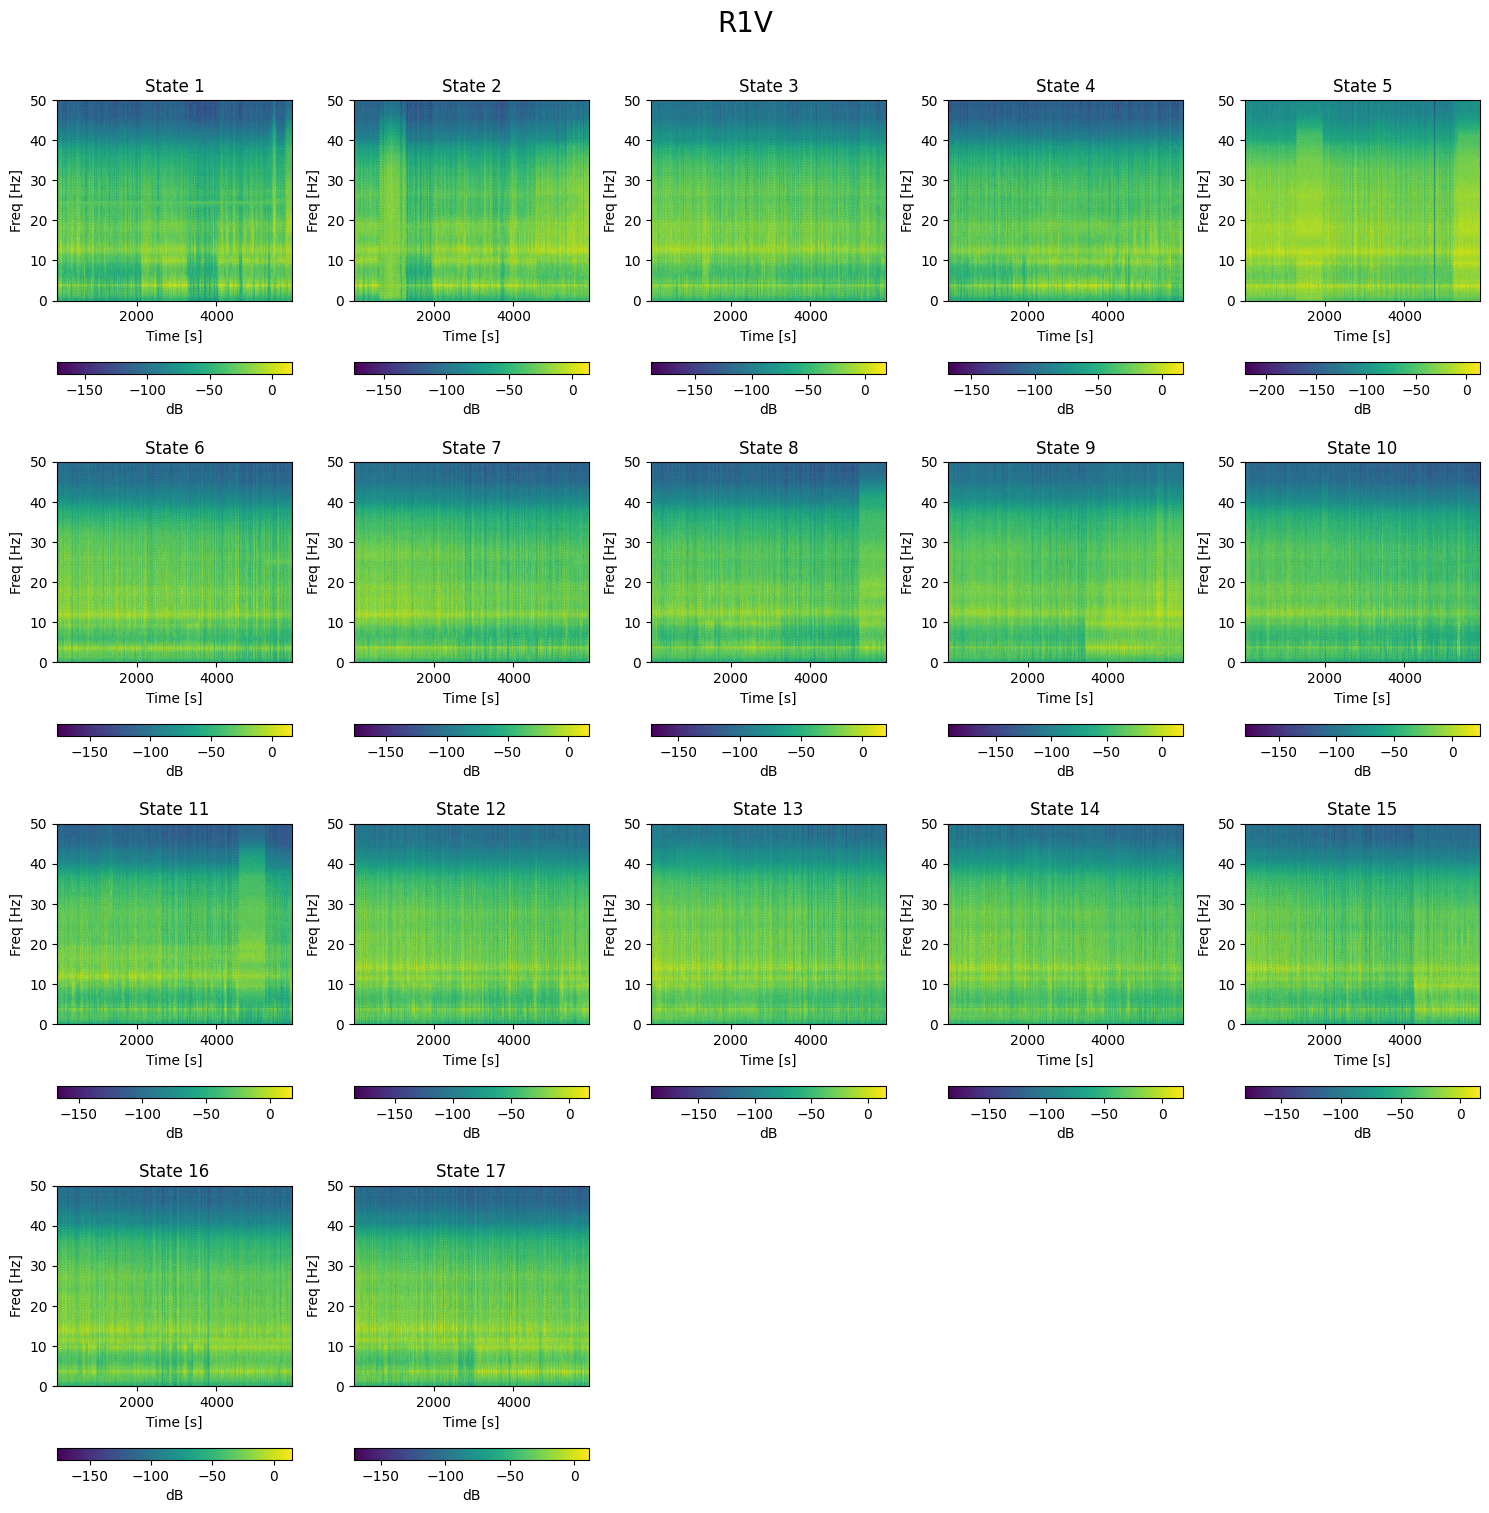

In [58]:
plot_spectrogram(r1v_signals, "R1V")

## ⚡ Fast Fourier Transform 

In [61]:
list_sensor_directions = dfs_preprocessed[0].columns.tolist()
list_sensor_directions

['R1V ', 'R2L ', 'R2T ', 'R2V ', 'R3V ']

In [72]:
from scipy.fftpack import fft, fftfreq

def plot_fft(dfs_preprocessed):

    fs = 100 #  the sample rate
    title = "Fast Fourier Transform"

    fig, axes = plt.subplots(5, 1, figsize=(10, 6*5))
    fig.suptitle(title, fontsize=20, y = 1.006)

    # Loop through the subplots
    for idx, ax in enumerate(axes):
        
        # The order is R1V, R2L, R2T, R2V, R3V
        signals = [df.iloc[:, idx].values for df in dfs_preprocessed]

        # Plot 17 line plots on the current subplot
        for i in range(17):

            # this should be constant for all signals around ~500,000
            n = len(signals[i])
            freqs = np.fft.fftfreq(n, 1/fs)[:n//2]
            yf = fft(signals[i])

            # Amplitude Spectrum
            amplitude_spectrum = np.abs(yf)[:n//2]

            # cycle thru a colormap
            unique_color = plt.cm.jet(i / 17)
            
            sns.lineplot(x=freqs, y=(amplitude_spectrum - np.mean(amplitude_spectrum))/np.std(amplitude_spectrum), label=f'State {i+1}', color=unique_color, ax=ax)
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Amplitude')
            ax.set_title(f'Fourier Transform of DS Classes using {list_sensor_directions[idx]}')
            ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

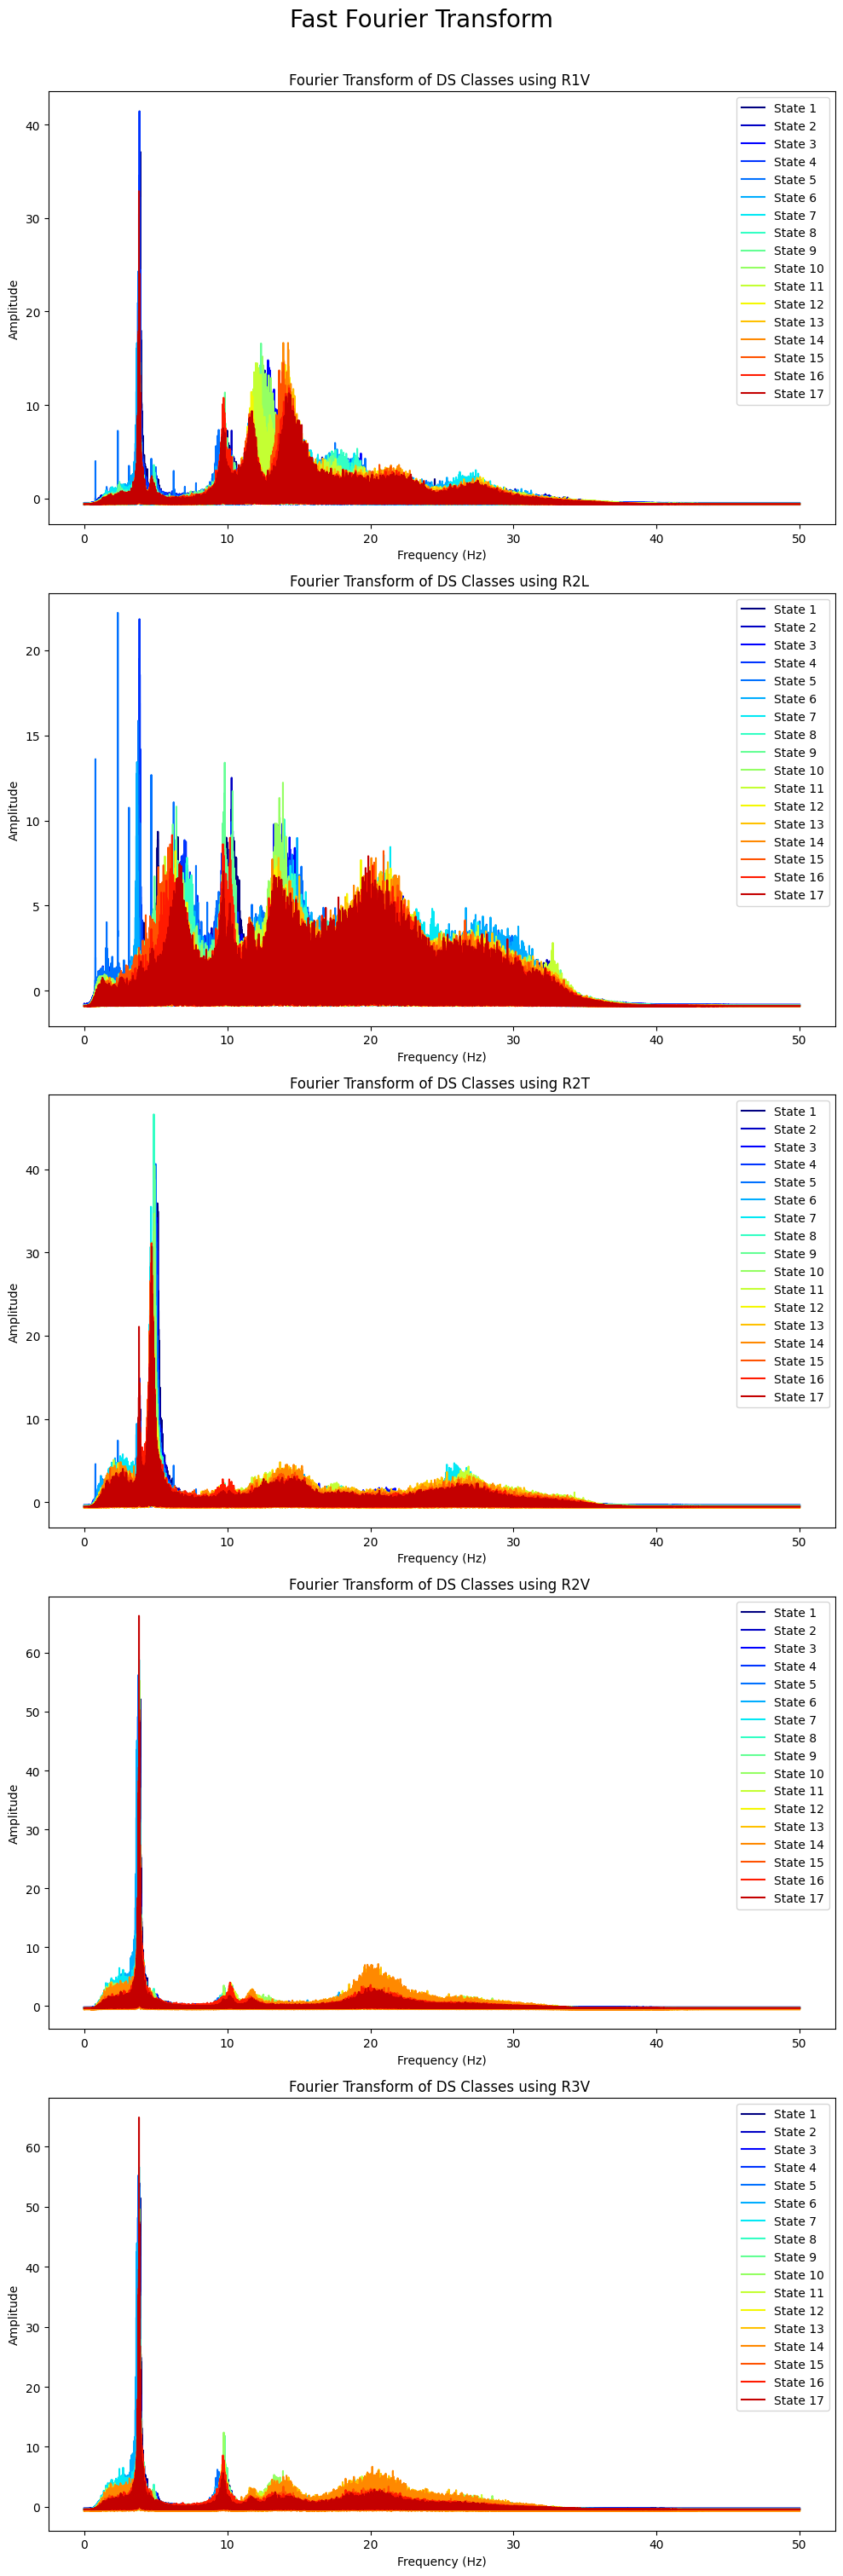

In [153]:
plot_fft(dfs_preprocessed)

## Feature Extraction

In [ ]:
from utils4 import get_features
fs = 100
test_features = [get_features(el, fs) for el in test_data]
print("test feature computation done")
train_features = [get_features(el, fs) for el in train_data]

In [12]:
test_features_np = np.array(test_features)
train_features_np = np.array(train_features)
test_features_np.shape, train_features_np.shape

((17, 5, 49), (595, 5, 49))

In [13]:
# Save the array for precomputation
np.save("train_shape_595_5_49.npy", train_features_np)
np.save("test_shape_17_5_49.npy", test_features_np)

## Data preprocessing

In [64]:
def data_preprocessing(data, valid_columns = None, imputer = None, scaler = None): # for training data, default is None. For test, other parameters should be passed
    from sklearn.impute import SimpleImputer
    X_flattened_unstd =   np.array([el.flatten() for el in data]) # unstd is short for unstandardized. Flatten all the channels into one 1D array for each observation
    X_valid_cols = []
    X_imputed = []
    X_std = []

    ## Remove columns with too many NANs
    if valid_columns == None:
        # Create a boolean mask for NaN values
        nan_mask = np.isnan(X_flattened_unstd)

        # Check for NaN values in each column and print the column indices with NaN values
        columns_with_nan = np.any(nan_mask, axis=0)
        nan_columns_indices = np.where(columns_with_nan)[0]

        nan_per_column = [np.sum(np.isnan(X_flattened_unstd[:, el])) if el in nan_columns_indices else 0 for el in range(X_flattened_unstd.shape[1])]
        valid_columns = np.array(nan_per_column) < (0.1*(X_train_unstd.shape[0])) # if more than 10 percent of a column is NaN, we ignore it 
        print(np.sum(valid_columns)) # we will sadly let go of 5 columns

        X_valid_cols = X_flattened_unstd[:, valid_columns]
    else:
        X_valid_cols = X_flattened_unstd[:, valid_columns]

    ## Impute missing values
    if imputer == None:
        imputer = SimpleImputer(strategy='mean')
        X_imputed = imputer.fit_transform(X_valid_cols)
    else:
        X_imputed = imputer.transform(X_valid_cols)

    ## Standardize the data
    if scaler == None:
        scaler = StandardScaler()
        X_std = scaler.fit_transform(X_imputed)
    else:
        X_std = scaler.transform(X_imputed)

    return X_std, valid_columns, imputer, scaler

In [65]:
X_train, valid_columns, imputer, scaler = data_preprocessing(train_features_np)
valid_columns

240


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## PCA

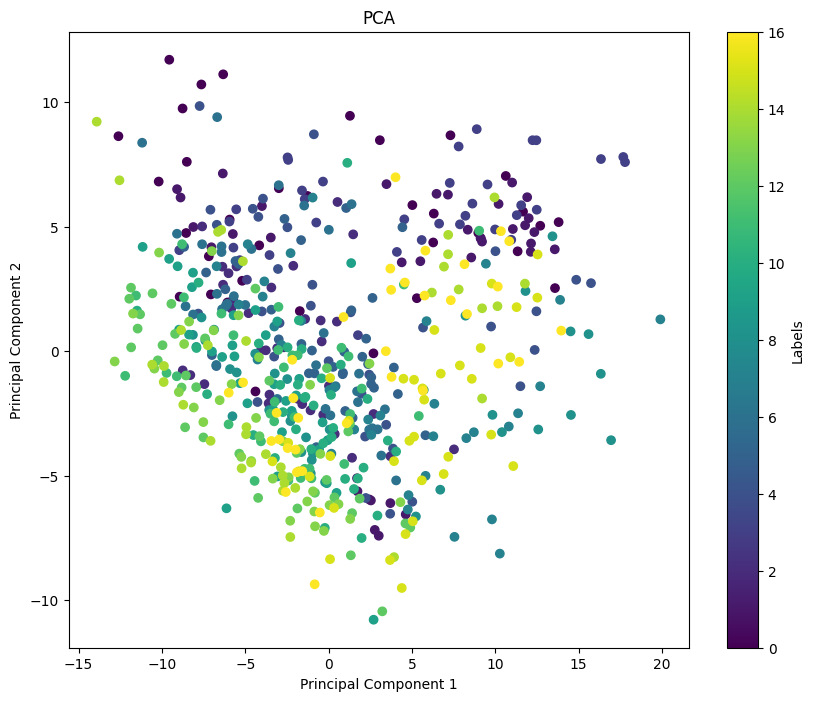

In [71]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) 
X_train_2D = pca.fit_transform(X_train)

# create figure and axes object
fig, ax1 = plt.subplots(figsize=(10, 8))

# scatter plot for PCA
sc = ax1.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=labels_train, cmap='viridis')
ax1.set_title("PCA")
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
cbar = plt.colorbar(sc, ax=ax1)
cbar.set_label('Labels')

# display the plot
plt.show()

## t-SNE

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X_train)

# create figure and axes object
fig, ax1 = plt.subplots(figsize=(10, 8))

# scatter plot for PCA
sc = ax1.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels_train, cmap='viridis')
ax1.set_title("t-SNE")
ax1.set_xlabel("t-SNE Dimension 1")
ax1.set_ylabel("t-SNE Dimension 2")
cbar = plt.colorbar(sc, ax=ax1)
cbar.set_label('Labels')

# display the plot
plt.show()